Wczytujemy pakiety

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

from PIL import Image

import cv2
import os

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from numpy import expand_dims

from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, ZeroPadding2D #average pooling, global average pooling can be taken as well, 
from keras.optimizers import Adam
from keras import callbacks
import datetime
import keras

Połączenie do Drive

In [5]:
drive.mount("/content/drive")

Mounted at /content/drive


Lokalizacje spektrogramów dla każdego zbioru

In [6]:
train_folder = "/content/drive/My Drive/01_Dane/02_Spektrogramy/01_Zdjecia/train/"
test_folder = "/content/drive/My Drive/01_Dane/02_Spektrogramy/01_Zdjecia/test/"
val_folder = "/content/drive/My Drive/01_Dane/02_Spektrogramy/01_Zdjecia/val/"

Jak wyglądają przykładowe spektrogramy?

Text(0.5, 1.0, 'Normal X-Ray')

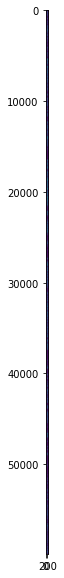

In [9]:
norm_image = Image.open(train_folder +'banswa/XC138517.png')

fig = plt.figure(figsize=(12,10))
img_plot = plt.imshow(norm_image, cmap = plt.cm.bone)
a1.set_title('Normal X-Ray', fontsize=12)

Aplikujemy przekształcenia, aby zwiększyć zbiór treningowy: shear_range (czyli ciągniemy obraz w stronę jednego z narożników, aż staje się pochyły), zoom_range (losowo przybliżamy i oddalamy obrazki), height_shift_range (przesuwamy obrazki do góry), width_shift_range (przesuwamy obrazki w prawo). Oraz skalowanie wartości. Dla zbiorów: testowego i walidacyjnego nie nakładamy przekształćeń, jedynie skalowanie.

In [7]:
train_datagen = ImageDataGenerator(rescale= 1./255, shear_range=0.2, zoom_range= 0.2, height_shift_range= 0.1, width_shift_range= 0.1, 
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator (rescale=1./255) 

Tworzenie batchy

In [8]:
train_set = train_datagen.flow_from_directory(train_folder, target_size=(224,224), batch_size= 32, class_mode='categorical')
test_set = test_datagen.flow_from_directory(test_folder, target_size=(224,224), batch_size= 32, class_mode='categorical')
val_set = test_datagen.flow_from_directory(val_folder, target_size=(224,224), batch_size= 32, class_mode='categorical')

Found 210 images belonging to 30 classes.
Found 60 images belonging to 30 classes.
Found 30 images belonging to 30 classes.


Definiujemy architekturę modelu

In [9]:
def build_model():
    model = Sequential()

    # Convolutional layer - I
    model.add(ZeroPadding2D((1,1), input_shape = train_set.image_shape))
    model.add(Conv2D(filters= 64, kernel_size=(3,3), activation= 'relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    # Convolutional layer - II
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters= 128, kernel_size=(3,3), activation= 'relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    # Convolutional layer - III
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters= 256, kernel_size=(3,3), activation= 'relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    # Convolutional layer - IV
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters= 512, kernel_size=(3,3), activation= 'relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(Flatten())

    # Fully Connected Layer
    model.add(Dense(units = 256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units= 30, activation='softmax'))

    # Learning Rate, optimizers-Adam
    adam_optimizer = Adam(learning_rate= 0.0001)

    # loss = categorical_crossentropy
    model.compile(optimizer = adam_optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [10]:
model = build_model()

Zdefiniowanie ścieżki do zapisów checkpointów

In [ ]:
filepath = "/content/drive/My Drive/01_Dane/ptaki_cnn.hdf5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor= 'val_loss', save_best_only=True, mode ='min', verbose=1)

Logi

In [ ]:
logdir = os.path.join("./logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(logdir)

Trening modelu

In [ ]:
history = model.fit_generator(generator=train_set, epochs=15, shuffle=True, 
                              validation_data= val_set, 
                              callbacks =[checkpoint, tensorboard_callback], verbose=1) 

Wczytanie wyestymownaych wag modelu

In [11]:
model.load_weights('/content/drive/My Drive/01_Dane/ptaki_cnn.hdf5')

Moc na zbiorze train

In [13]:
model.evaluate(train_set)

7/7 [==============================] - 232s 36s/step - loss: 3.4013 - accuracy: 0.0429


[3.401256799697876, 0.04285714402794838]

Moc na zbiorze testowym

In [12]:
model.evaluate(test_set)

2/2 [==============================] - 56s 7s/step - loss: 3.4012 - accuracy: 0.0222


[3.401202917098999, 0.03333333507180214]

In [ ]:
#https://www.kaggle.com/amritvirsinghx/cnn-under-30-mins-chest-x-raytutorial